# Collaborative Filtering

### **Import Required Libraries**

In [84]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt

from sklearn.decomposition import NMF
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
from IPython.display import HTML

### **Configure Display Settings**

In [85]:
%matplotlib notebook

### **Import Files**

The data is sourced from CareerBuilder.com's [Job Recommendation Challenge](https://www.kaggle.com/c/job-recommendation/data), hosted on Kaggle in 2012.

**Users**

*users.tsv - Holds all users and their metadata*

In [86]:
# File Preview
users = pd.read_csv("data/users.tsv", sep="\t")
users.head(5)

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


**Jobs**

*jobs.tsv: Holds the jobs available on CareerBuilder.com during a 13-day window*

In [87]:
# File preview for jobs listed in the first of the seven windows
jobs1 = pd.read_csv("data/jobs1.tsv", sep="\t", error_bad_lines=False)
jobs1.head(5)

len(jobs1)



b'Skipping line 122433: expected 11 fields, saw 12\n'
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


285091

In [88]:
jobs1[jobs1["JobID"] == 481587]

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate


**Apps**

*apps.tsv: Holds the applications users submitted*

In [89]:
# File preview
apps = pd.read_csv("data/apps.tsv", sep="\t")
apps.head(5)

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [90]:
total_jobs = apps["JobID"].value_counts()
total_users = apps["UserID"].value_counts()

# Filter job and user ID's so that only jobs with more than a given number of applications are retained
# This is to reduce sparsity to the maximum acceptable level of 99.5%
jobs_filtered = total_jobs[total_jobs > 15].to_frame().reset_index().rename(columns={"index": "JobID", 
                                                                                    "JobID": "count"})
users_filtered = total_users[total_users > 15].to_frame().reset_index().rename(columns={"index": "UserID", 
                                                                                    "UserID": "count"})

# Filter apps dataset so that only jobs and users that exceed the threshold are included
apps = apps[apps["JobID"].isin(jobs_filtered["JobID"]) & apps["UserID"].isin(users_filtered["UserID"])]

### Create Matrix

**Filter Data to Window 1 Only**

In [38]:
# Filter users, jobs, and applications to include only those assigned to first window and then retrieve and sort ids
window1_app_ids = apps.query("WindowID == 1")[["UserID", "JobID"]]
# Identify unique user ID's in filtered apps data
window1_user_ids = window1_app_ids["UserID"].sort_values().unique()
# Identify unique job ID's in filtered apps data
window1_job_ids = np.sort(apps["JobID"].unique())


# Make doubly sure that all job IDs in applications dataset match job IDs in jobs dataset
window1_app_ids = window1_app_ids[window1_app_ids["JobID"].isin(window1_job_ids)]


# Determine data counts
window1_num_apps = len(window1_app_ids)
window1_num_users = len(window1_user_ids)
window1_num_jobs = len(window1_job_ids)
print(f'''The first window had:\n
    - {window1_num_jobs:,} open job listings
    - {window1_num_users:,} active users
    - {window1_num_apps:,} apps submitted by active users to a subset of those jobs''')

The first window had:

    - 7,527 open job listings
    - 1,848 active users
    - 40,646 apps submitted by active users to a subset of those jobs


In [39]:
window1_app_ids

,UserID,JobID
51,554,196603
52,554,300053
53,554,1078274
54,554,146817
55,554,654538
...,...,...
353465,1471624,465
353466,1471624,924757
353468,1471624,282716
353469,1471624,300527


**Prepare Row and Column Data for Matrix**

In [40]:
# Create id-index lookups
window1_user_lookup = {val: idx for idx, val in enumerate(window1_user_ids.tolist())}
window1_job_lookup = {val: idx for idx, val in enumerate(window1_job_ids)}

# Initialize values for CSR ("Compressed Sparse Row") matrix
data = [1] * len(window1_app_ids)
rows = window1_app_ids["UserID"].apply(lambda id: window1_user_lookup[id]).tolist()
columns = window1_app_ids["JobID"].apply(lambda id: window1_job_lookup[id]).tolist()

print(len(rows))
print(len(columns))
print(len(data))

40646
40646
40646


**Create Matrix**

In [41]:
# Create CSR matrix
# For background on the use of sparse matrices, please see:
# https://towardsdatascience.com/why-we-use-sparse-matrices-for-recommender-systems-2ccc9ab698a4

csr = csr_matrix(
    arg1=(data, (rows, columns)),
    shape=(window1_num_users, window1_num_jobs), 
    dtype=np.int8)

# Calculate sparsity - percentage of empty/zero entries in matrix
matrix_size = csr.shape[0]*csr.shape[1] # Number of possible interactions in the matrix
num_apps = len(csr.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_apps/matrix_size))
sparsity

99.70779076996693

The sparsity of this matrix is 99.5%, the maximum acceptable level.

[0.0, 1.0]
(207, 2184)


1.3273809523809523

**Preview Matrix (Scroll Down to See Figure)**

<IPython.core.display.Javascript object>


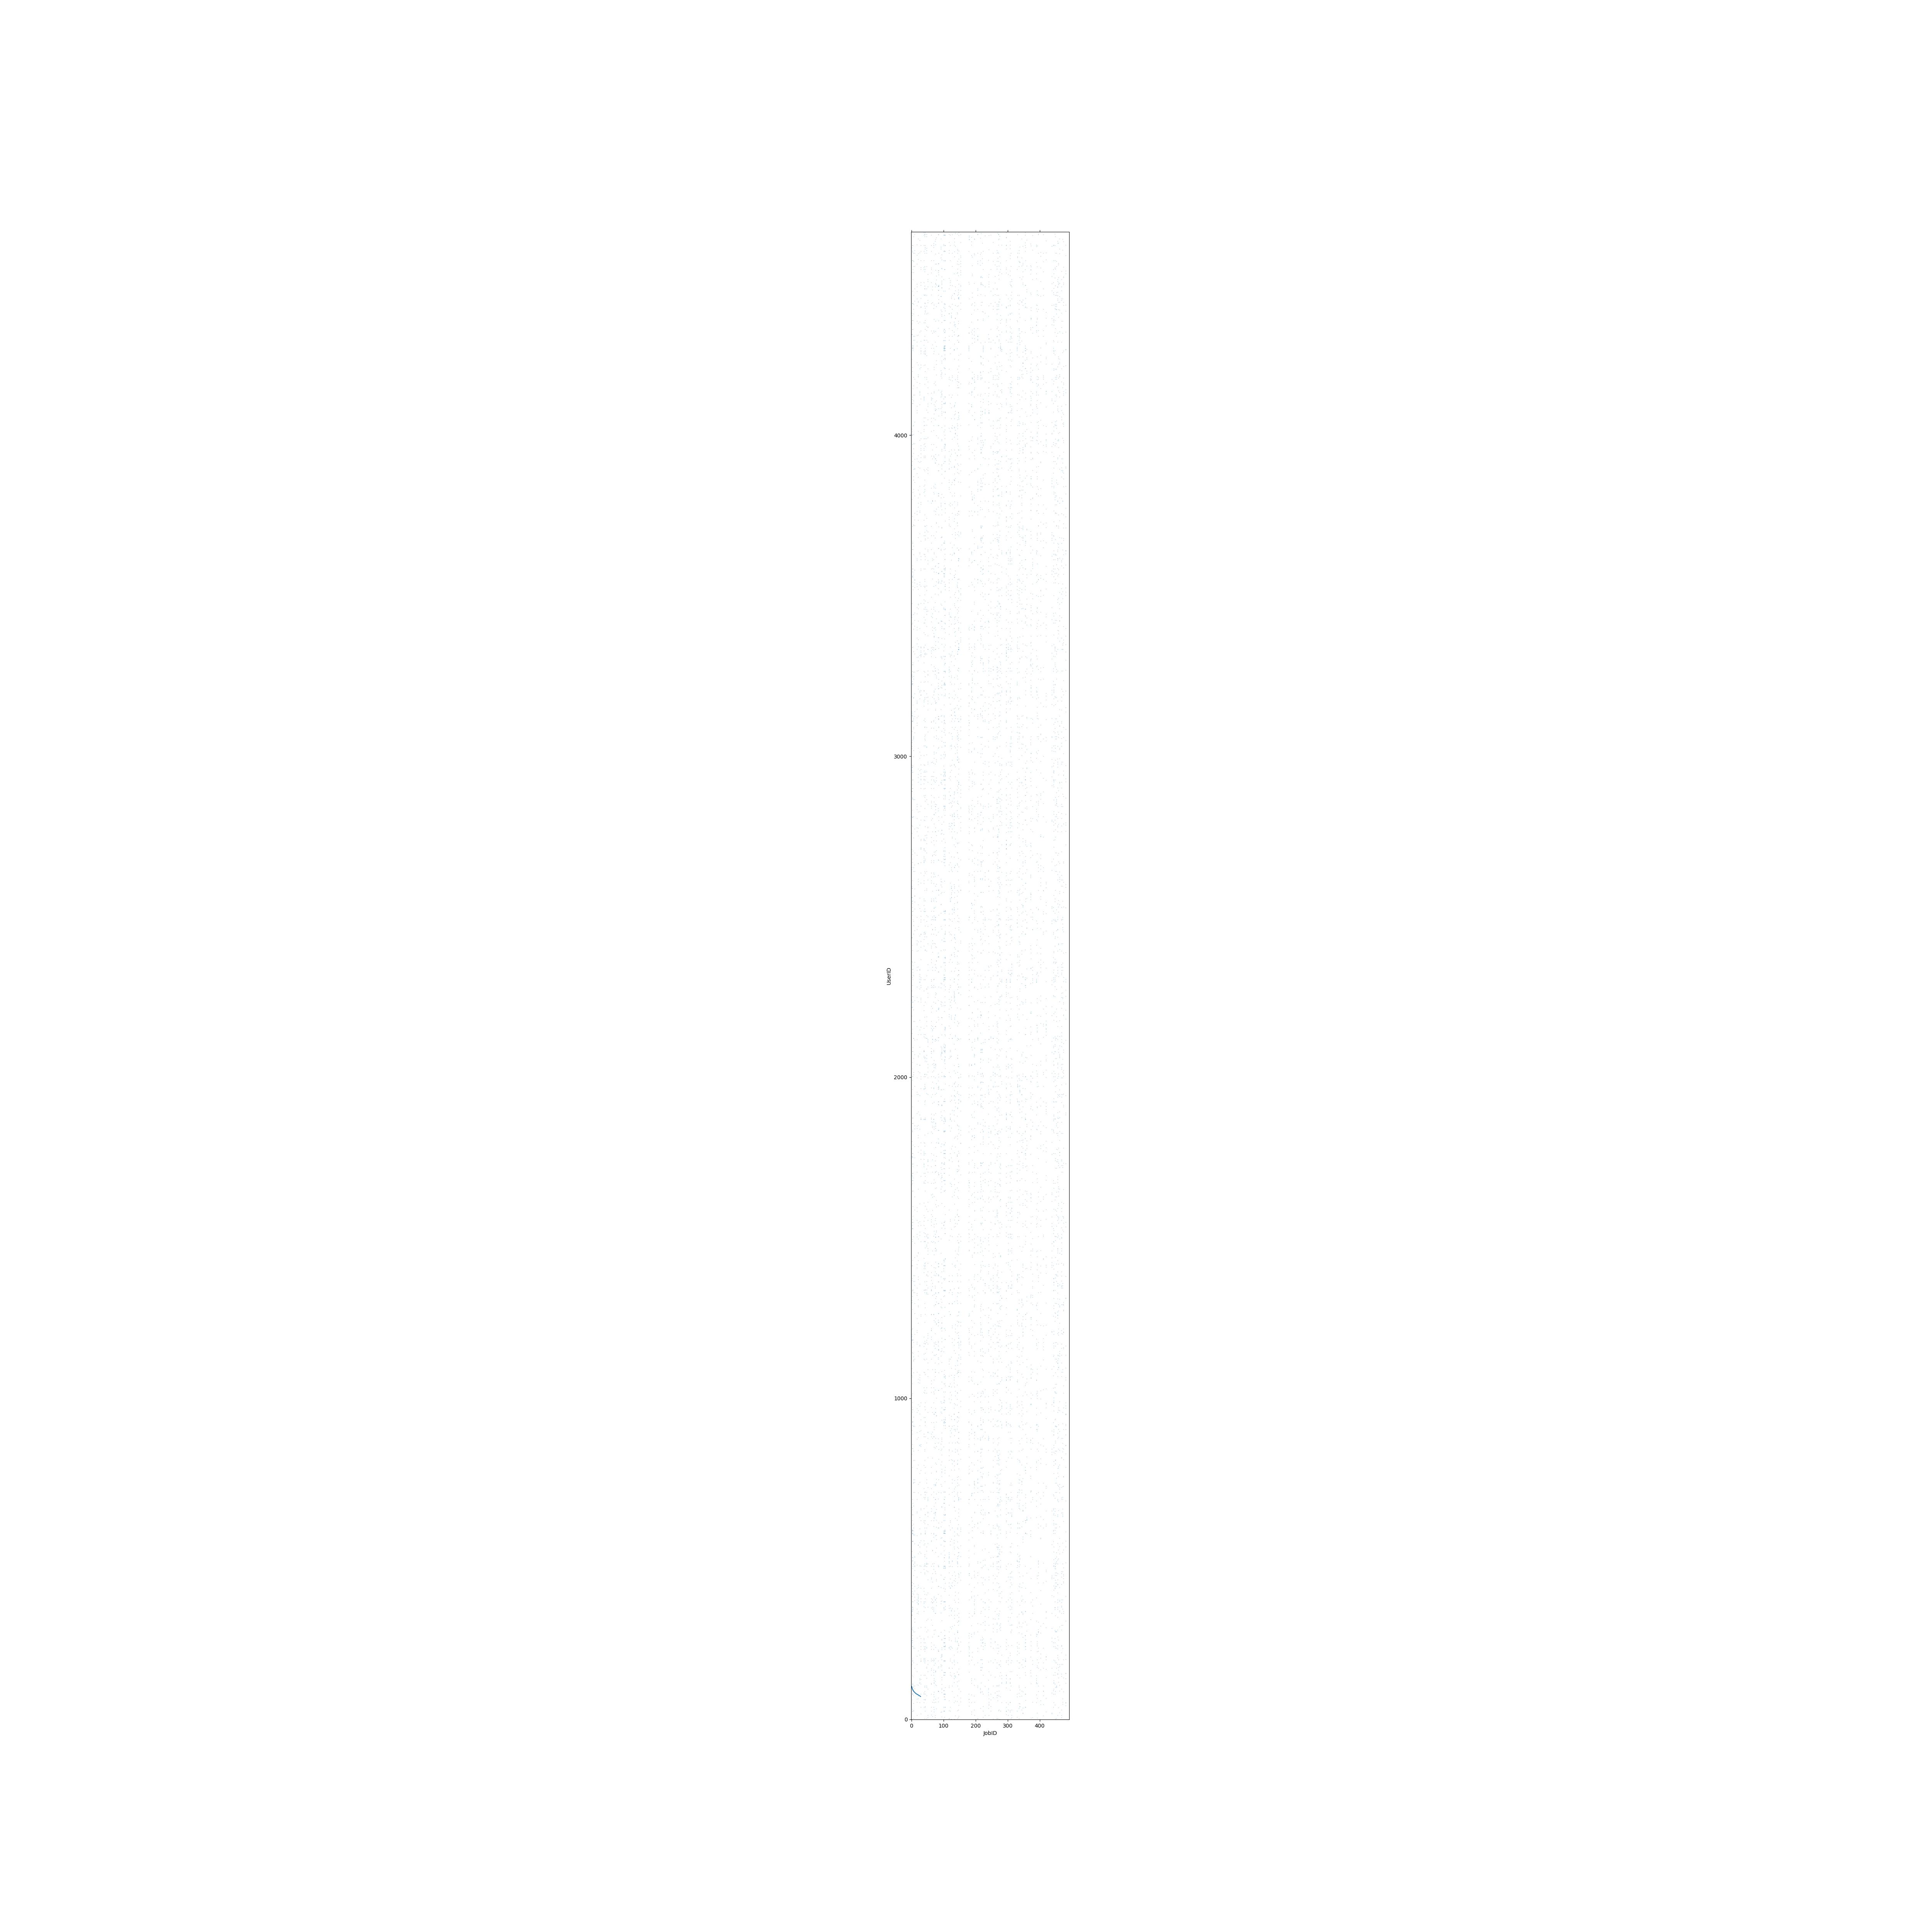

In [215]:
# Preview first several hundred rows
fig = plt.figure(figsize=(50, 50))
tick_range = np.arange(0, 8000, 100)
plt.yticks(tick_range, list(tick_range))

plt.xlabel("JobID")
plt.ylabel("UserID")

display(HTML("<h4>CSR Matrix Preview</h4>"))
plt.spy(csr, markersize = 0.1, origin="lower")

# Note: There is a lot of whitespace around the figure, but you can view it by scrolling down.
# You can also zoom in by scrolling to the bottom left corner of the screen and selecting the square button.

### Apply Non-Negative Matrix Factorization (NMF)

**Outstanding Questions**

How does the sklearn library's NMF implementation compare to others?
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- https://github.com/benfred/implicit

How should we divide the data to perform cross validation?  Some references:  

- https://towardsdatascience.com/how-to-use-cross-validation-for-matrix-completion-2b14103d2c4c
- http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/
- https://jessesw.com/Rec-System/
- https://arxiv.org/pdf/0909.3052.pdf
- https://stats.stackexchange.com/questions/111205/how-to-choose-an-optimal-number-of-latent-factors-in-non-negative-matrix-factori
- https://pdfs.semanticscholar.org/0265/769b0fbf86bb0e700573c80e388bb54c3f7a.pdf

What metric should we use for accuracy?

 - http://fastml.com/evaluating-recommender-systems/
 - https://stackoverflow.com/questions/7410030/how-to-check-my-item-based-collaborative-filtering-algo-is-correct

Fairness Paper:
- https://proceedings.neurips.cc/paper/2017/file/e6384711491713d29bc63fc5eeb5ba4f-Paper.pdf

Other Helpful Links:

General Recommender Systems
- https://towardsdatascience.com/recommender-systems-in-practice-cef9033bb23a
- https://www.prem-melville.com/publications/recommender-systems-eml2010.pdf
- https://realpython.com/build-recommendation-engine-collaborative-filtering/

NMF

- https://mlexplained.com/2017/12/28/a-practical-introduction-to-nmf-nonnegative-matrix-factorization/
- https://medium.com/logicai/non-negative-matrix-factorization-for-recommendation-systems-985ca8d5c16c
- http://www.billconnelly.net/?p=534
- https://www.slideshare.net/BenjaminBengfort/non-negative-matrix-factorization
- https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
- https://arxiv.org/pdf/1401.5226.pdf

In [271]:
def perform_nmf(k):
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(csr)
    H = model.components_
    return model.reconstruction_err_

In [ ]:
# Note - Matrix Factorization for k = 2:

# CSR Matrix
# ------------
# csr.shape
# (77060, 285155)

# User-Related Aspect
# ------------
# W.shape
# (77060, 2)

# Job-Related Aspect
# ------------
# H.shape
# (2, 285155)

### Cross Validation
Train and test split and evaluation metrics are taken from the following blog post mentioned above: https://jessesw.com/Rec-System/.

In [287]:
def make_train(ratings, pct_test = 0.2, random_seed=None):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(random_seed) # Set the random seed for reproducibility - defaults to zero
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  


In [259]:
import random
data_train, data_test, data_altered = make_train(csr, pct_test = 0.2)

model = NMF(n_components=10, init='random', random_state=0)
user_vecs, item_vecs = model.fit_transform(data_train), model.components_
#H = model.components_

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [262]:
from sklearn import metrics
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr) 

In [265]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark


In [338]:
### CROSS VALIDATION ATTEMPT ###
# High-level overview: split data into different training and test sets using
# different random seeds. For each train/test split, identify the optimal
# number of latent features according to mean AUC score for each user.
# The AUC score is the area under the ROC curve for a given user, which
# is a plot of the true positive rate (true positives/total positives) against
# the false positive rate (false positives/)
# Function to get a key from a dictionary correpsonding to a particular value
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

# Initialize list of auc metrics
aucs = []
# Initalize list of best number of latent features at each iteration
best_latent_features = []
best_alphas = []

# Generate list of regularization parameters to try
alphas = [0, 0.0001, 0.001, 0.01, 0.1, 0.25]

# Iterate over range of random seeds
for i in range(10):
    # Split data into training and test - different random seeds will ensure different
    # splits of data
    data_train, data_test, data_altered = make_train(csr, pct_test = 0.2, random_seed=i)
    # Keep track of auc metrics for each number of 
    cv_auc = {}
    
    # Iterate over range of latent features
    for j in range(1, 20):
        for alpha in alphas:
            # Define model
            # initialized estimates using non-negative double SVD, which is better for sparseness
            # 
            model = NMF(n_components=j, init='nndsvd', max_iter=500, random_state=0, alpha=alpha)
            # Fit model on training data
            user_vecs, item_vecs = model.fit_transform(data_train), model.components_

            # Calculate mean AUC on test data
            mean_auc, popularity_auc = calc_mean_auc(data_train, data_altered, 
                                                     [csr_matrix(user_vecs), csr_matrix(item_vecs)], data_test)
            # Keep track of AUC score corresponding to each number of latent features and regularization param
            cv_auc[(j, alpha)] = mean_auc
    # Define the "best" number of latent features as the one with the highest AUC
    best_latent_feature = get_key(cv_auc, max(cv_auc.values()))[0]
    best_alpha = get_key(cv_auc, max(cv_auc.values()))[1]
    best_alphas.append(best_alpha)
    #plt.plot(cv_auc)
    best_latent_features.append(best_latent_feature)
    cv_auc_mean = np.mean(list(cv_auc.values()))
    aucs.append(cv_auc_mean)
    


/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of ite

/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of ite

/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of ite

/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of ite

/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of ite

In [339]:
print("Mean AUC: {}".format(np.mean(aucs)))

# Define best number of latent features as rounded mean of best latent features across random seeds
overall_best_latent_feature = int(np.round(np.mean(best_latent_features)))
overall_best_alpha = np.mean(best_alphas)
print("Optimal number of latent features: {}".format(overall_best_latent_feature))
print("Optimal regularization parameter: {}".format(overall_best_alpha))

Mean AUC: 0.9543719298245614
Optimal number of latent features: 17
Optimal regularization parameter: 0.025


Next steps: fit entire (filtered) dataset using optimal hyperparameters.

In [343]:
model = NMF(n_components=17, init='nndsvd', max_iter=500, random_state=0, alpha=0.025)
            # Fit model on training data
user_vecs, item_vecs = model.fit_transform(csr), model.components_

/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


#### Experimentation/Scratchwork

In [272]:
k_values = [k for k in range(1, 30)]
reconstruction_errors = []
for k in k_values:
    reconstruction_errors.append(perform_nmf(k))
    


/home/ndignazio/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [273]:
reconstruction_errors

[102.53536690956297,
 98.53946513357322,
 95.08063616918078,
 92.87309067366363,
 91.44072416765556,
 89.22478270359616,
 87.28716968547596,
 86.62750838306752,
 85.45458525353783,
 84.20588213707885,
 83.40860737000548,
 82.33257030932415,
 81.5047335223653,
 80.40321840634991,
 79.78523402516709,
 79.19086106314674,
 78.3837964007727,
 77.92557108742145,
 77.75454352370033,
 76.66539680191222,
 76.19607508001397,
 75.75612296164768,
 74.93498243656785,
 74.3449310702962,
 73.60667300893351,
 73.17199931896282,
 72.52912612475953,
 71.74703546393735,
 71.12184133690234]

In [275]:
%matplotlib inline

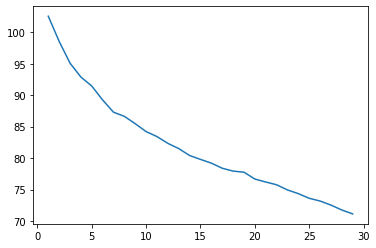

In [276]:
plt.plot(k_values, reconstruction_errors)

In [ ]:
k_values2 = [k for k in range(30, 60)]
reconstruction_errors2 = []
for k in k_values2:
    reconstruction_errors2.append(perform_nmf(k))

In [ ]:
plt.plot(k_values2, reconstruction_errors2)

In [ ]:
reconstruction_errors2

### Playing Around with Separating by User Groups

First, create a dataframe of the user lookup to match matrix indices to User ID's.

In [42]:
data = {'replacement': list(window1_user_lookup.values()), 
        'UserID': list(window1_user_lookup.keys())} 

data = pd.DataFrame(data)
data.head()

,replacement,UserID
0,0,554
1,1,769
2,2,1697
3,3,2652
4,4,4359


Then, recode the educational status values of the user dataset to fit our desired schema.

In [43]:
df = users[["UserID", "DegreeType"]].replace({"Associate's": "Bachelor's", 
                             "Vocational": "Bachelor's", 
                             "Master's": "PostGrad", 
                             "PhD": "PostGrad"})

Merge the data to create one dataframe with original User ID, row index in the sparse matrix, and educational status. Then separate indices by education status and convert to lists.

In [44]:
lookup = data.merge(df, on="UserID", how="inner")
lookup.head()

,replacement,UserID,DegreeType
0,0,554,Bachelor's
1,1,769,Bachelor's
2,2,1697,High School
3,3,2652,High School
4,4,4359,High School


In [45]:
high_school_indices = lookup[lookup["DegreeType"] == "High School"]["replacement"].tolist()
bachelors_indices = lookup[lookup["DegreeType"] == "Bachelor's"]["replacement"].tolist()
postgrad_indices = lookup[lookup["DegreeType"] == "PostGrad"]["replacement"].tolist()

Create matrix factorization model using optimal hyperparameters.

In [46]:
model = NMF(n_components=17, init='nndsvd', max_iter=10000, random_state=0, alpha=0.025)
            # Fit model on training data
user_vecs, item_vecs = model.fit_transform(csr), model.components_

high_school_users = user_vecs[high_school_indices,:]
pred = high_school_users.dot(item_vecs)

Calculate RMSE (as an easy example metric) on whole matrix.

In [51]:
from numpy import linalg as la
from sklearn.metrics import roc_auc_score

pred = user_vecs.dot(item_vecs)
np.mean(np.linalg.norm(csr-pred, axis=0)**2)


rows, cols = pred.shape

scores = []
for i in range(rows):
    pred_row = pred[i,:]
    actual_row = csr[i,:].toarray().reshape((7527, 1))
    score = roc_auc_score(actual_row, pred_row)
    scores.append(score)
    
np.mean(scores)
#roc_auc_score(csr[0,:].toarray().reshape((2184,1)), pred[0,:])

0.990088617352351

In [53]:
high_school_pred = pred[high_school_indices,:]
high_school_actual = csr[high_school_indices,:]

rows, cols = high_school_pred.shape
scores = []
for i in range(rows):
    pred_row = pred[i,:]
    actual_row = csr[i,:].toarray().reshape((7527, 1))
    score = roc_auc_score(actual_row, pred_row)
    scores.append(score)
    
np.mean(scores)

0.9908733196642939

In [54]:
college_pred = pred[bachelors_indices,:]
college_actual = csr[bachelors_indices,:]

rows, cols = college_pred.shape

scores = []
for i in range(rows):
    pred_row = pred[i,:]
    actual_row = csr[i,:].toarray().reshape((7527, 1))
    score = roc_auc_score(actual_row, pred_row)
    scores.append(score)
    
np.mean(scores)

0.9895682137842222

In [56]:
postgrad_pred = pred[postgrad_indices,:]
postgrad_actual = csr[postgrad_indices,:]

rows, cols = postgrad_pred.shape

scores = []
for i in range(rows):
    pred_row = pred[i,:]
    actual_row = csr[i,:].toarray().reshape((7527, 1))
    score = roc_auc_score(actual_row, pred_row)
    scores.append(score)
    
np.mean(scores)

0.9917091264660798

In [150]:
1/3322 * np.sum(abs((high_school_pred.mean(axis=0) - np.mean(high_school_pred)) - (postgrad_pred.mean(axis=0) - np.mean(postgrad_pred))))

0.004425801288198736

In [146]:
1/3322 * np.sum((high_school_pred.mean(axis=0) - np.mean(high_school_pred)) - (college_pred.mean(axis=0) - np.mean(college_pred)))

-4.728975255402157e-18

In [147]:
1/3322 * np.sum((college_pred.mean(axis=0) - np.mean(college_pred)) - (postgrad_pred.mean(axis=0) - np.mean(postgrad_pred)))

5.180149573055366e-19

In [131]:
postgrad_pred.shape

(55, 3322)

In [134]:
high_school_pred.mean(axis=0).shape

(3322,)

In [172]:
def value_unfairness(advantaged, disadvantaged):
    '''
    measures inconsistency in signed estimation error across
    the user types
    
    Value unfairness occurs when one class of user is consistently given higher or lower predictions
    than their true preferences. If the errors in prediction are evenly balanced between overestimation
    and underestimation or if both classes of users have the same direction and magnitude of error, the
    value unfairness becomes small. Value unfairness becomes large when predictions for one class
    are consistently overestimated and predictions for the other class are consistently underestimated.
    '''
    rows, cols = advantaged.shape
    n = cols
    print(n)
    ddiff = disadvantaged.mean(axis=0) - np.mean(disadvantaged)
    adiff = advantaged.mean(axis=0) - np.mean(advantaged)
    return 1/ n * np.sum(abs(ddiff - adiff))

def absolute_unfairness(advantaged, disadvantaged):
    '''
    measures inconsistency in absolute estimation error
    across user types
    
    Absolute unfairness is unsigned, so it captures a single statistic representing the quality of prediction
    for each user type. If one user type has small reconstruction error and the other user type has large
    4reconstruction error, one type of user has the unfair advantage of good recommendation, while the
    other user type has poor recommendation. In contrast to value unfairness, absolute unfairness does
    not consider the direction of error. For example, if female students are given predictions 0.5 points
    below their true preferences and male students are given predictions 0.5 points above their true
    preferences, there is no absolute unfairness.
    '''
    rows, cols = advantaged.shape
    n = cols
    print(n)
    ddiff = abs(disadvantaged.mean(axis=0) - np.mean(disadvantaged))
    adiff = abs(advantaged.mean(axis=0) - np.mean(advantaged))
    return 1/ n * np.sum(abs(ddiff - adiff))

def underestimation_unfairness(advantaged, disadvantaged):
    '''
    measures inconsistency in how much the
    predictions underestimate the true ratings
    '''
    rows, cols = advantaged.shape
    n = cols
    print(n)
    ddiff =  (np.mean(disadvantaged) - disadvantaged.mean(axis=0)).clip(min=0)
    adiff = (np.mean(advantaged) - advantaged.mean(axis=0)).clip(min=0)
    return 1 / n * np.sum(abs(ddiff - adiff))

def overestimation_unfairness(advantaged, disadvantaged):
    
    rows, cols = advantaged.shape
    n = cols
    print(n)
    ddiff = (disadvantaged.mean(axis=0) - np.mean(disadvantaged)).clip(min=0)
    adiff = (advantaged.mean(axis=0) - np.mean(advantaged)).clip(min=0)
    return 1 / n * np.sum(abs(ddiff - adiff))
    
    
value_unfairness(high_school_pred, postgrad_pred)


3322


0.004425801288198736

In [154]:
absolute_unfairness(high_school_pred, college_pred)

3322


0.0025688995204187944

In [151]:
value_unfairness(high_school_pred, college_pred)

3322


0.0025817670132914096

In [169]:
overestimation_unfairness(high_school_pred, postgrad_pred)

3322


0.0027074302898932086

In [167]:
underestimation_unfairness(high_school_pred, postgrad_pred)

3322


0.001718370998305527

In [159]:
advantaged = postgrad_pred
diffs = np.mean(advantaged) - advantaged.mean(axis=0)

In [160]:
diffs.clip(min=0)

array([0.        , 0.00330095, 0.00330095, ..., 0.00330095, 0.00330095,
       0.        ])

In [161]:
diffs

array([-0.00536968,  0.00330095,  0.00330095, ...,  0.00330095,
        0.00330095, -0.00613694])

In [175]:
ed = [high_school_pred, college_pred, postgrad_pred]
funcs = [value_unfairness, absolute_unfairness, underestimation_unfairness, overestimation_unfairness]

value = np.zeros((len(ed), len(ed)))
for i, val in enumerate(ed):
    for j, val2 in enumerate(ed):
        value[i,j] = value_unfairness(val, val2)


3322
3322
3322
3322
3322
3322
3322
3322
3322


In [176]:
value

array([[0.        , 0.00258177, 0.0044258 ],
       [0.00258177, 0.        , 0.00338724],
       [0.0044258 , 0.00338724, 0.        ]])